In [5]:
import pandas as pd
import numpy as np

In [6]:
data = pd.read_csv('data.csv',encoding='gbk')

In [7]:
data.shape

(4754, 90)

In [8]:
delete = ['Unnamed: 0', 'custid', 'trade_no', 'bank_card_no','id_name','latest_query_time','source','loans_latest_time','first_transaction_time', 'student_feature']
data = data.drop(delete,axis=1)
data.shape

(4754, 80)

In [9]:
# 使用众数填充
from sklearn.impute import SimpleImputer
for i in range(data.shape[1]):
    feature = data.iloc[:,i].values.reshape(-1,1)  #sklearn中特征矩阵必须是二维
    imp_mode = SimpleImputer(strategy='most_frequent')
    data.iloc[:,i] = imp_mode.fit_transform(feature)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 80 columns):
low_volume_percent                            4754 non-null float64
middle_volume_percent                         4754 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4754 non-null float64
trans_activity_month                          4754 non-null float64
trans_activity_day                            4754 non-null float64
transd_mcc                                    4754 non-null float64
trans_days_interval_filter                    4754 non-null float64
trans_days_interval                           4754 non-null float64
regiol_mobility                               4754 non-null float64
repayment_capability                          4754 non-null int64
is_high_user                                  4754 non-null int64
number_of_trans_from_2011                     4754 non-null float64
historical_tran

In [11]:
# 处理分类型特征
from sklearn.preprocessing import OrdinalEncoder
data['reg_preference_for_trad'] = OrdinalEncoder().fit_transform(data['reg_preference_for_trad'].values.reshape(-1,1))

In [12]:
data.shape

(4754, 80)

In [13]:
from sklearn.model_selection import train_test_split
x = data.drop('status',axis=1)
y = data.status
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.3,random_state =2018,shuffle = True) 

In [14]:
#y_train[y_train == 1].size,y_test[y_test == 1].size ,y_train[y_train == 0].size,y_test[y_test == 0].size
X_train.shape[0], X_test.shape[0], y_train.size, y_test.size

(3327, 1427, 3327, 1427)

In [15]:
# 随机森林
from sklearn.ensemble import RandomForestClassifier
forset = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)# 等于-1的时候，表示cpu里的所有core进行工作或者直接填写cpu数
forset.fit(x, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [16]:
# 2)输出重要特征
importances = forset.feature_importances_
indices = np.argsort(importances)[::-1]
feature_labels = data.columns[1:]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feature_labels[indices[f]], importances[indices[f]]))

 1) trans_fail_top_count_enum_last_6_month 0.050370
 2) history_fail_fee               0.045400
 3) loans_score                    0.036386
 4) apply_score                    0.030430
 5) latest_one_month_fail          0.024723
 6) loans_overdue_count            0.022307
 7) avg_consume_less_12_valid_month 0.018350
 8) max_consume_count_later_6_month 0.018116
 9) is_high_user                   0.016978
10) first_transaction_day          0.016672
11) top_trans_count_last_1_month   0.016412
12) historical_trans_day           0.016252
13) avg_price_top_last_12_valid_month 0.016231
14) trans_fail_top_count_enum_last_12_month 0.016065
15) trans_activity_month           0.015925
16) consume_mini_time_last_1_month 0.015638
17) latest_query_day               0.015612
18) jewelry_consume_count_last_6_month 0.014922
19) transd_mcc                     0.014920
20) rank_trad_1_month              0.014903
21) trans_day_last_12_month        0.014853
22) consfin_avg_limit              0.014649
23) lo

In [17]:
FI_RF = pd.DataFrame({"Feature Importance":forset.feature_importances_}, index=X_train.columns)

In [18]:
import matplotlib.pyplot as plt
FI_RF.sort_values('Feature Importance').plot(kind = 'barh', figsize =(15,25))
plt.xticks(rotation = 90)

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]),
 <a list of 7 Text xticklabel objects>)

In [19]:
# 3)筛选重要特征
threshold = 0.01
x_selected = X_train.loc[:, importances > threshold]
print('原数据特征数{}, 通过随机森林筛选后的特征数{}, 剔除了{:.2%}的特征'\
      .format(data.shape[1], x_selected.shape[1], (data.shape[1]-x_selected.shape[1])/data.shape[1]))

原数据特征数80, 通过随机森林筛选后的特征数50, 剔除了37.50%的特征


### 用逻辑回归、svm和决策树；随机森林和XGBoost进行模型构建，评分方式任意，如准确率等。（不需要考虑模型调参）

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score

# 数据归一化
from sklearn.preprocessing import minmax_scale
X_train = minmax_scale(X_train)
X_test =  minmax_scale(X_test)

In [23]:
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

In [24]:
import warnings
warnings.filterwarnings("ignore")

LR = LogisticRegression()
LR.fit(X_train,y_train)

svc = SVC(kernel='linear',probability=True)
svc.fit(X_train,y_train)

DT = DecisionTreeClassifier(max_depth=6)
DT.fit(X_train,y_train)

RF = RandomForestClassifier()
RF.fit(X_train,y_train)

XGB = XGBClassifier()
XGB.fit(X_train,y_train)

models = [LR,svc,DT,RF,XGB]

In [25]:
names = ["LR","SVC", 'DT', "RF","Xgb"]
evaluates = ['accuracy','precision','recall','f1','auc']

In [26]:
df_list = []
for name,model in zip(names,models):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    #accuracy
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
    #precision   
    train_precision = precision_score(y_train,y_train_pred)
    test_precision = precision_score(y_test,y_test_pred)   
    #recall
    train_recall = recall_score(y_train,y_train_pred)
    test_recall = recall_score(y_test,y_test_pred)   
    #f1
    train_f1 = f1_score(y_train,y_train_pred)
    test_f1 = f1_score(y_test,y_test_pred)   
    #auc 计算时，计算的应该是不同的概率画出来的曲线下的面积,而不是预测值对应的曲线下的面积
    #预测值 分类模型，应该全是0 或者 1 ，但是概率是类似于得分一样的值
    #根据资料貌似两种都行，都可以作为阈值来进行ROC曲线的绘制
    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]
    
    train_auc = roc_auc_score(y_train,y_train_pred)
    test_auc = roc_auc_score(y_test,y_test_pred)
    print('{}  训练集： accuracy:{:.3},precision:{:.3}, recall:{:.3}, f1:{:.3}, auc:{:.3}'.format(name,train_accuracy,train_precision,train_recall,train_f1,train_auc))
    print('{}  测试集： accuracy:{:.3},precision:{:.3}, recall:{:.3}, f1:{:.3}, auc:{:.3}'.format(name,test_accuracy,test_precision,test_recall,test_f1,test_auc))
    print('\n')
    df = pd.DataFrame(np.array([train_accuracy,train_precision,train_recall,train_f1,train_auc,test_accuracy,test_precision,test_recall,test_f1,test_auc]).reshape(2,-1),
                  index = ['train','test'],
                  columns = ['Accuracy','Precision','Recall','F1-Score','AUC-Score'])
    df_list.append(df)

pd.concat(df_list,axis=0,keys=names)

LR  训练集： accuracy:0.801,precision:0.749, recall:0.312, f1:0.44, auc:0.808
LR  测试集： accuracy:0.786,precision:0.627, recall:0.37, f1:0.466, auc:0.77


SVC  训练集： accuracy:0.796,precision:0.787, recall:0.257, f1:0.387, auc:0.816
SVC  测试集： accuracy:0.773,precision:0.645, recall:0.217, f1:0.325, auc:0.773


DT  训练集： accuracy:0.843,precision:0.773, recall:0.53, f1:0.629, auc:0.836
DT  测试集： accuracy:0.643,precision:0.361, recall:0.549, f1:0.436, auc:0.675


RF  训练集： accuracy:0.981,precision:0.997, recall:0.926, f1:0.96, auc:1.0
RF  测试集： accuracy:0.724,precision:0.445, recall:0.398, f1:0.421, auc:0.701


Xgb  训练集： accuracy:0.849,precision:0.861, recall:0.476, f1:0.613, auc:0.917
Xgb  测试集： accuracy:0.77,precision:0.564, recall:0.379, f1:0.453, auc:0.757




Accuracy  Precision    Recall  F1-Score  AUC-Score
LR  train  0.801323   0.749280  0.311751  0.440305   0.808443
    test   0.786265   0.627358  0.370474  0.465849   0.770310
SVC train  0.796213   0.786765  0.256595  0.386980   0.816116
    test   0.772950   0.644628  0.217270  0.325000   0.773007
DT  train  0.843102   0.772727  0.529976  0.628734   0.835945
    test   0.642607   0.361468  0.548747  0.435841   0.675215
RF  train  0.980763   0.997416  0.925659  0.960199   0.999550
    test   0.723896   0.445483  0.398329  0.420588   0.700789
Xgb train  0.849414   0.861171  0.476019  0.613127   0.916829
    test   0.770147   0.564315  0.378830  0.453333   0.756763

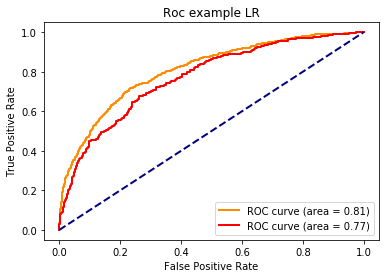

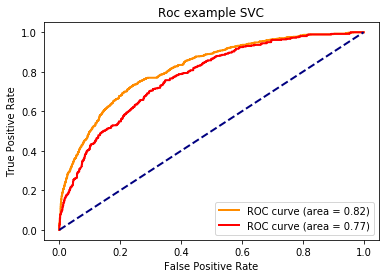

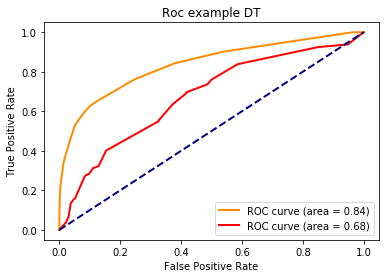

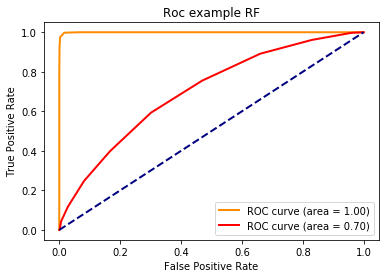

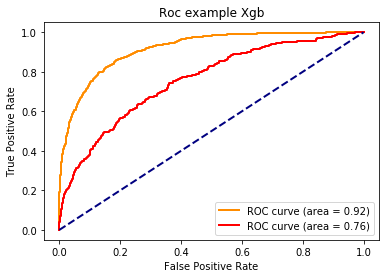

In [27]:
def draw_roc_curve(train_pre_proba,test_pre_proba,train_auc,test_auc,model_name):
    fpr,tpr,roc_auc = train_pre_proba
    test_fpr,test_tpr,test_roc_auc = test_pre_proba
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % train_auc)
    plt.plot(test_fpr, test_tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' %test_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Roc example '+ model_name)
    plt.legend(loc="lower right")
    plt.show()
for name,model in zip(names,models):
    
    y_train_pred = model.predict_proba(X_train)[:,1]
    y_test_pred = model.predict_proba(X_test)[:,1]


    train_roc = roc_curve(y_train,y_train_pred)
    test_roc = roc_curve(y_test,y_test_pred)

    train_auc = roc_auc_score(y_train,y_train_pred)
    test_auc = roc_auc_score(y_test,y_test_pred)
    

    draw_roc_curve(train_roc,test_roc,train_auc,test_auc,name)

**结论：**
可以明显看到，随机森林明显过拟合，XGB拟合也比较严重
ROC针对的是二分类问题，对于多酚类问题需要转化为二分类问题

**Refenerces：**

[使用5种分类模型进行用户贷款逾期预测](http://yezuolin.com/2018/11/TheModelofUserLoanOverdueEvaluation/)

[客户贷款逾期预测\[2\]-svm和决策树模型](https://blog.csdn.net/truffle528/article/details/84168200)

[LittleSix](https://github.com/LittleSix1/Datawhale/blob/master/Datawhale.ipynb)


# 参数调优

In [28]:
from sklearn.model_selection import  GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
param = {'n_estimators':[10,100],'max_depth':[2,3]}
clf = GridSearchCV(model,param_grid = param,cv=5)
clf.fit(X_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [29]:
clf.cv_results_

{'mean_fit_time': array([0.0383544 , 0.31553388, 0.04999647, 0.38184099]),
 'std_fit_time': array([0.00955388, 0.05467417, 0.00625022, 0.04208371]),
 'mean_score_time': array([0.00672884, 0.01751256, 0.00937452, 0.01776662]),
 'std_score_time': array([0.00529983, 0.00325682, 0.00765427, 0.00323466]),
 'param_max_depth': masked_array(data=[2, 2, 3, 3],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[10, 100, 10, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 2, 'n_estimators': 10},
  {'max_depth': 2, 'n_estimators': 100},
  {'max_depth': 3, 'n_estimators': 10},
  {'max_depth': 3, 'n_estimators': 100}],
 'split0_test_score': array([0.75525526, 0.76576577, 0.76426426, 0.77027027]),
 'split1_test_score': array([0.75675676, 0.75375375, 0.77627628, 0.77027027]),
 'split2_test_score': array([0.75225225, 0.75525526,

In [30]:
print(clf.best_params_,clf.best_score_)
(pd.DataFrame(clf.cv_results_)[['params','mean_test_score','std_test_score']])

{'max_depth': 3, 'n_estimators': 10} 0.7733694018635408


,params,mean_test_score,std_test_score
0,"{'max_depth': 2, 'n_estimators': 10}",0.755936,0.004424
1,"{'max_depth': 2, 'n_estimators': 100}",0.758942,0.004241
2,"{'max_depth': 3, 'n_estimators': 10}",0.773369,0.005062
3,"{'max_depth': 3, 'n_estimators': 100}",0.770965,0.000608


- 定义函数，方便后期直接调用

In [31]:
class grid():
    def __init__(self,model):
        self.model = model
    def grid_get(self,X,y,param_grid):
        
        grid_search = GridSearchCV(self.model,param_grid,cv=5,scoring='accuracy',refit = False)
        #refit参数 交叉验证结束后是否还会用最好的参数进行fit，可以加入predict函数来测试一下
        grid_search.fit(X,y)
        
        print(grid_search.best_params_,grid_search.best_score_)
        
        return pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']]

### SVM

In [32]:
# 这里对训练和测试集进行一个PCA 减少运行时间  用线性核时间很短 用lbf貌似收敛不了

pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
grid(SVC()).grid_get(X_train,y_train,{'kernel':['linear'],'C':[0.1,1,10]})

{'C': 0.1, 'kernel': 'linear'} 0.7493237150586114


,params,mean_test_score,std_test_score
0,"{'C': 0.1, 'kernel': 'linear'}",0.749324,0.000368
1,"{'C': 1, 'kernel': 'linear'}",0.749324,0.000368
2,"{'C': 10, 'kernel': 'linear'}",0.749324,0.000368


### Logistic Regission

In [33]:
# logistic regission
grid(LogisticRegression()).grid_get(X_train,y_train,{'penalty':['l2'],'solver':[ 'lbfgs', 'liblinear','sag']})

{'penalty': 'l2', 'solver': 'lbfgs'} 0.7658551247370003


,params,mean_test_score,std_test_score
0,"{'penalty': 'l2', 'solver': 'lbfgs'}",0.765855,0.005725
1,"{'penalty': 'l2', 'solver': 'liblinear'}",0.765855,0.005725
2,"{'penalty': 'l2', 'solver': 'sag'}",0.765855,0.005725


### Decision Tree

In [34]:
# Decision Tree
grid(DecisionTreeClassifier()).grid_get(X_train,y_train,{'max_depth':[4,5,6,7,8]})

{'max_depth': 5} 0.7403065825067628


,params,mean_test_score,std_test_score
0,{'max_depth': 4},0.739705,0.008439
1,{'max_depth': 5},0.740307,0.004261
2,{'max_depth': 6},0.734896,0.009487
3,{'max_depth': 7},0.727382,0.007027
4,{'max_depth': 8},0.720469,0.017261


### 随机森林

In [35]:
# Random Forest
grid(RandomForestClassifier()).grid_get(X_train,y_train,{'n_estimators':[10,100],'max_depth':[2,3]})

{'max_depth': 2, 'n_estimators': 10} 0.7493237150586114


,params,mean_test_score,std_test_score
0,"{'max_depth': 2, 'n_estimators': 10}",0.749324,0.000368
1,"{'max_depth': 2, 'n_estimators': 100}",0.749324,0.000368
2,"{'max_depth': 3, 'n_estimators': 10}",0.749324,0.000901
3,"{'max_depth': 3, 'n_estimators': 100}",0.749324,0.000368


### Xgboost

In [36]:
grid(XGBClassifier()).grid_get(X_train,y_train,{'max_depth':[3,4], 'learning_rate':[0.1,1], 'n_estimators':[50,100]})

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100} 0.765253982566877


,params,mean_test_score,std_test_score
0,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.764052,0.003232
1,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.765254,0.007608
2,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.764352,0.001609
3,"{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",0.760745,0.004935
4,"{'learning_rate': 1, 'max_depth': 3, 'n_estima...",0.718365,0.014002
5,"{'learning_rate': 1, 'max_depth': 3, 'n_estima...",0.709348,0.015689
6,"{'learning_rate': 1, 'max_depth': 4, 'n_estima...",0.707544,0.010397
7,"{'learning_rate': 1, 'max_depth': 4, 'n_estima...",0.708446,0.007314
